In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

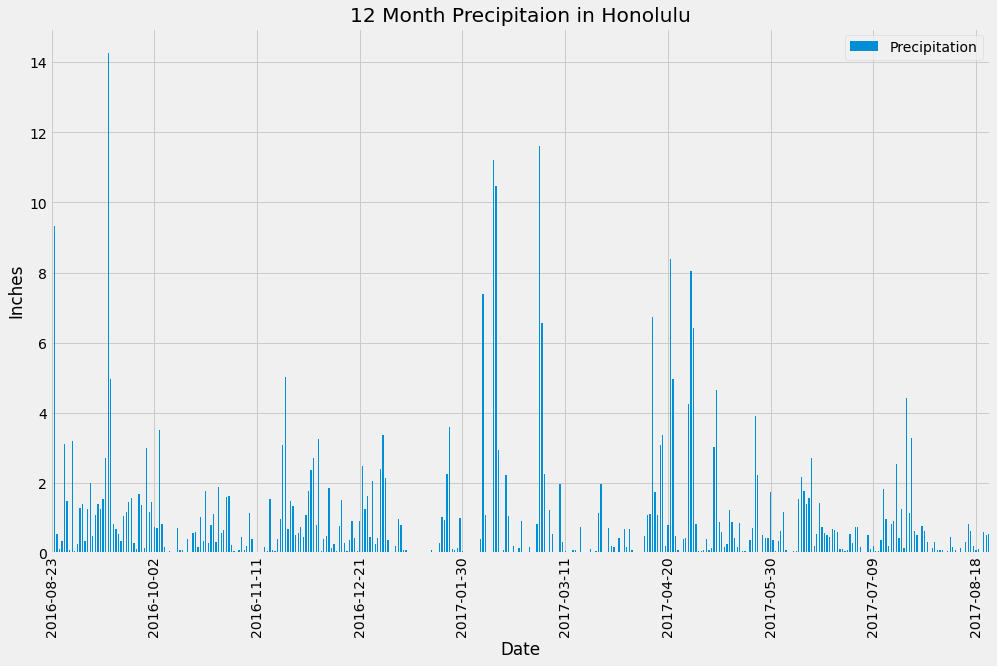

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
sbydate=session.query(Measurement).order_by(Measurement.date.desc()).first()
year=int(sbydate.date[0:4])
month=int(sbydate.date[5:7])
day=int(sbydate.date[8:10])
query_date=dt.date(year,month,day)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query_period=session.query(Measurement.date,Measurement.prcp).\
                    filter(Measurement.date >= str(query_date)).\
                    filter(Measurement.prcp != "NaN").\
                    order_by(Measurement.date.desc()).all()

#for date in query_period:
#    print(f"{date.date},{date.prcp}")

# Save the query results as a Pandas DataFrame and set the index to the date column
query_df=pd.DataFrame(query_period, columns=['Date','Precipitation'])

# Sort the dataframe by date
query_by_df=query_df.groupby(['Date']).sum()

# Use Pandas Plotting with Matplotlib to plot the data
bar_chart=query_by_df.plot(kind='bar',title='12 Month Precipitaion in Honolulu',figsize=(15,9))
plt.xticks(np.arange(query_by_df.shape[0])[::40], query_by_df.index[::40])
bar_chart.set(xlabel='Date', ylabel='Inches')
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_by_df.describe()

,Precipitation
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(func.distinct(Measurement.station))).all()

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station=='USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Station with the highest tempurature observations:  USC00519281


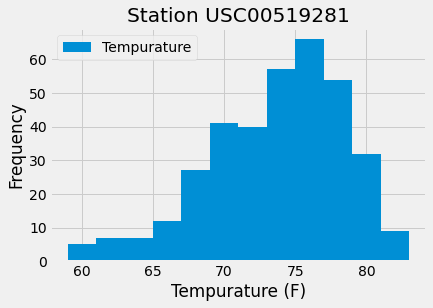

In [15]:
# Choose the station with the highest number of temperature observations.
highest_tobs=session.query(Measurement.station, func.count(Measurement.tobs)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).first()
print('Station with the highest tempurature observations: ',highest_tobs.station)

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sbydate=session.query(Measurement).\
                filter(Measurement.station==highest_tobs.station).\
                order_by(Measurement.date.desc()).first()
year=int(sbydate.date[0:4])
month=int(sbydate.date[5:7])
day=int(sbydate.date[8:10])
query_date=dt.date(year,month,day)-dt.timedelta(days=365)
query_period=session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station==highest_tobs.station).\
                    filter(Measurement.date >= str(query_date)).\
                    filter(Measurement.tobs != "NaN").\
                    order_by(Measurement.date.desc()).all()
query_df=pd.DataFrame(query_period, columns=['Date','Tempurature'])
bar_chart=query_df.plot(kind='hist', bins=12 ,title=f'Station {highest_tobs.station}')
bar_chart.set(xlabel='Tempurature (F)', ylabel='Frequency')
plt.show()

## Bonus Challenge Assignment

In [132]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [133]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Dates used for my 10 day trip are in 2016, being the dataset does not have November dates in year 2017, which is the last
#      year in this dataset.
start_date='2016-11-20'
end_date='2016-11-30'
results=calc_temps(start_date,end_date)
print(results)

[(67.0, 74.32352941176471, 80.0)]


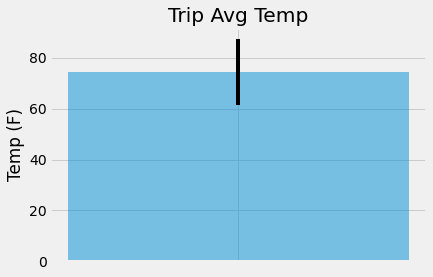

In [155]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
max=results[0][2]
min=results[0][0]
avg=results[0][1]
error=max-min
x = np.arange(1)
fig, bc = plt.subplots()
bc.bar(x, avg,
        yerr=error,
        align='center',
        alpha=0.5,
        ecolor='black',
        tick_label='',
        capsize=0)
bc.set_ylabel('Temp (F)')
bc.set_title('Trip Avg Temp')
plt.show()


In [63]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel=[Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
results=session.query(*sel).filter(Measurement.station==Station.station).\
            filter(start_date<=Measurement.date).filter(end_date>=Measurement.date).\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()
for result in results:
    (sname,slat,slng,sele,sprcp) = result
    print(f"Name:{sname}, Latitude:{slat}, Longitude:{slng}, Elevation:{sele}, Precip:{sprcp}")

Name:MANOA LYON ARBO 785.2, HI US, Latitude:21.3331, Longitude:-157.8025, Elevation:152.4, Precip:9.219999999999999
Name:WAIHEE 837.5, HI US, Latitude:21.45167, Longitude:-157.84888999999998, Elevation:32.9, Precip:3.5499999999999994
Name:WAIMANALO EXPERIMENTAL FARM, HI US, Latitude:21.33556, Longitude:-157.71139, Elevation:19.5, Precip:1.2200000000000002
Name:KANEOHE 838.1, HI US, Latitude:21.4234, Longitude:-157.8015, Elevation:14.6, Precip:1.0400000000000003
Name:WAIKIKI 717.2, HI US, Latitude:21.2716, Longitude:-157.8168, Elevation:3.0, Precip:0.63
Name:KUALOA RANCH HEADQUARTERS 886.9, HI US, Latitude:21.5213, Longitude:-157.8374, Elevation:7.0, Precip:0.12
Name:PEARL CITY, HI US, Latitude:21.3934, Longitude:-157.9751, Elevation:11.9, Precip:None


In [106]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [128]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Start and end dats already set above.....
#     start_date
#     end_date

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

results=session.query(func.strftime("%m-%d",Measurement.date)).\
            filter(start_date<=Measurement.date).filter(end_date>=Measurement.date).\
            group_by(Measurement.date).\
            order_by(Measurement.date).all()

# Loop through the list of %m-%d strings and calculate the normals for each date
# Print results of calculations for each date in the list.
# Created dictionary within the same loop containing date, min_tmp, avg_tmp, and max_tmp.
all_dates=[]
for rdate in results:
    all_dates_dict={}
    date=str(rdate)
    date=date[2:7]
    dn_results=daily_normals(date)
    all_dates_dict["Date"]=date
    all_dates_dict["Min_tmp"]=dn_results[0][0]
    all_dates_dict["Avg_tmp"]=dn_results[0][1]
    all_dates_dict["Max_tmp"]=dn_results[0][2]
    all_dates.append(all_dates_dict)
    print(f"Date: {date} Daily Normals:{dn_results}")

Date: 11-20 Daily Normals:[(67.0, 73.03921568627452, 80.0)]
Date: 11-21 Daily Normals:[(66.0, 73.34, 81.0)]
Date: 11-22 Daily Normals:[(65.0, 71.98, 80.0)]
Date: 11-23 Daily Normals:[(64.0, 72.2, 80.0)]
Date: 11-24 Daily Normals:[(66.0, 72.56521739130434, 77.0)]
Date: 11-25 Daily Normals:[(63.0, 72.43181818181819, 78.0)]
Date: 11-26 Daily Normals:[(67.0, 73.51063829787235, 78.0)]
Date: 11-27 Daily Normals:[(63.0, 73.03921568627452, 78.0)]
Date: 11-28 Daily Normals:[(62.0, 72.75510204081633, 80.0)]
Date: 11-29 Daily Normals:[(62.0, 71.01960784313725, 79.0)]
Date: 11-30 Daily Normals:[(61.0, 71.8076923076923, 79.0)]


In [129]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Created a dataframe for the dictionary which was created above.
all_dates_pd=pd.DataFrame.from_dict(all_dates)
all_dates_pd=all_dates_pd.set_index('Date')
all_dates_pd

,Min_tmp,Avg_tmp,Max_tmp
Date,,,
11-20,67.0,73.039216,80.0
11-21,66.0,73.340000,81.0
11-22,65.0,71.980000,80.0
11-23,64.0,72.200000,80.0
11-24,66.0,72.565217,77.0
11-25,63.0,72.431818,78.0
11-26,67.0,73.510638,78.0
11-27,63.0,73.039216,78.0
11-28,62.0,72.755102,80.0


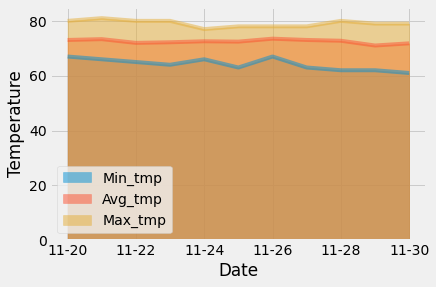

In [169]:
# Plot the daily normals as an area plot with `stacked=False`
import warnings
warnings.filterwarnings("ignore")
all_dates_pd.plot(kind='area',stacked=False)
plt.ylabel('Temperature')
plt.legend(loc='best')
plt.show()

# Conclusion of my trip 11-20 thru 11-30 to Hawaii based on my analysis:

    1) I will be packing for temperatures that average basically in the low 70's.
    2) Will not be staying in places of higher elevations due to the amount of rain they tend to get.
    3) ALOHA..!!!!!!!